In [2]:
import segmentation_models as sm

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

sm.set_framework('tf.keras')

from cnn.input import PascalVOC2012Dataset, Dataloader, get_training_augmentation, get_preprocessing, visualize, denormalize, get_validation_augmentation

import os

import matplotlib.pyplot as plt

import numpy as np

import random

random.seed(0)

Segmentation Models: using `keras` framework.


2022-07-24 20:22:45.298489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 20:22:45.451545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 20:22:45.451665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
train_dataset_descriptor_filepath = os.path.join(
    'pascalvoc12',
    'VOCdevkit',
    'VOC2012',
    'ImageSets',
    'Segmentation',
    'train.txt',
)

val_dataset_descriptor_filepath = os.path.join(
    'pascalvoc12',
    'VOCdevkit',
    'VOC2012',
    'ImageSets',
    'Segmentation',
    'val.txt',
)

images_path = os.path.join(
    'pascalvoc12', 
    'VOCdevkit', 
    'VOC2012', 
    'JPEGImages'
)

masks_path = os.path.join(
    'pascalvoc12', 
    'VOCdevkit', 
    'VOC2012', 
    'SegmentationClass'
) 

In [4]:
image_height = 384
image_width = 384
backbone = 'resnet50'
batch_size = 16
num_classes = 21
num_channels = 3

In [5]:
train_dataset = PascalVOC2012Dataset(
    train_dataset_descriptor_filepath,
    images_path=images_path,
    masks_path=masks_path,
    image_height=image_height,
    image_width=image_width,
    #augmentation=get_training_augmentation(image_height, image_width),
    augmentation=get_validation_augmentation(image_height, image_width),
    preprocessing=get_preprocessing(sm.get_preprocessing(backbone)),
)

val_dataset = PascalVOC2012Dataset(
    val_dataset_descriptor_filepath,
    images_path=images_path,
    masks_path=masks_path,
    image_height=image_height,
    image_width=image_width,
    augmentation=get_validation_augmentation(image_height, image_width),
    preprocessing=get_preprocessing(sm.get_preprocessing(backbone)),
)

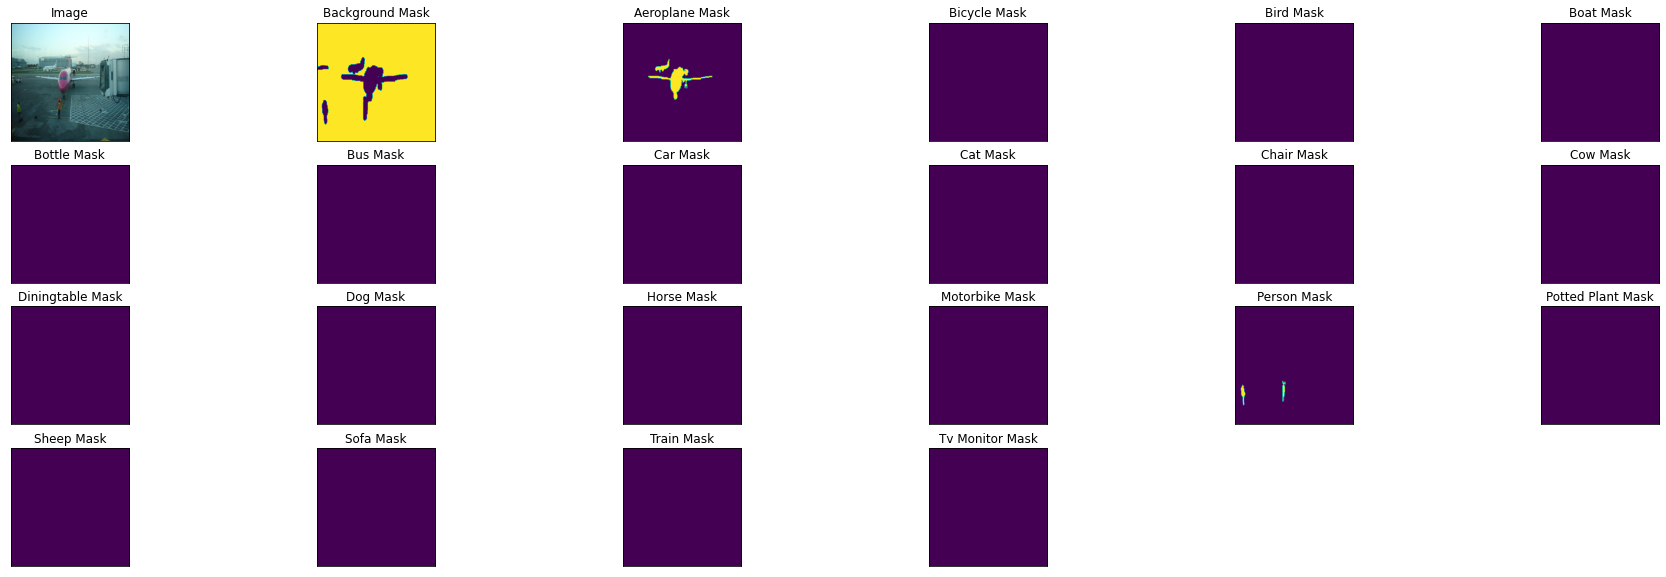

In [6]:
image, mask = train_dataset[0] # get some sample

visualize(
    image=image, 
    background_mask=mask[..., 0].squeeze(),
    aeroplane_mask=mask[..., 1].squeeze(),
    bicycle_mask=mask[..., 2].squeeze(),
    bird_mask=mask[..., 3].squeeze(),
    boat_mask=mask[..., 4].squeeze(),
    bottle_mask=mask[..., 5].squeeze(),
    bus_mask=mask[..., 6].squeeze(),
    car_mask=mask[..., 7].squeeze(),
    cat_mask=mask[..., 8].squeeze(),
    chair_mask=mask[..., 9].squeeze(),
    cow_mask=mask[..., 10].squeeze(),
    diningtable_mask=mask[..., 11].squeeze(),
    dog_mask=mask[..., 12].squeeze(),
    horse_mask=mask[..., 13].squeeze(),
    motorbike_mask=mask[..., 14].squeeze(),
    person_mask=mask[..., 15].squeeze(),
    potted_plant_mask=mask[..., 16].squeeze(),
    sheep_mask=mask[..., 17].squeeze(),
    sofa_mask=mask[..., 18].squeeze(),
    train_mask=mask[..., 19].squeeze(),
    tv_monitor_mask=mask[..., 20].squeeze(),
)

In [7]:
train_dataloader = Dataloader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = Dataloader(val_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# check shapes for errors
assert train_dataloader[0][0].shape == (batch_size, image_height, image_width, num_channels)
assert train_dataloader[0][1].shape == (batch_size, image_height, image_width, num_classes)

# check shapes for errors
assert val_dataloader[0][0].shape == (batch_size, image_height, image_width, num_channels)
assert val_dataloader[0][1].shape == (batch_size, image_height, image_width, num_classes)

In [9]:
net = sm.PSPNet(backbone, classes=num_classes, activation='softmax', encoder_weights='imagenet', encoder_freeze=False)

2022-07-24 20:22:55.932401: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-24 20:22:55.933901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 20:22:55.934050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 20:22:55.934135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [10]:
net.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 384, 384, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 390, 390, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 192, 192, 64  9408        ['zero_padding2d[0][0]']   

In [11]:
#import tensorflow.keras.backend as K

# def dice_coef_20cat(y_true, y_pred, smooth=1e-7):
#     y_true_f = K.flatten(y_true[..., 1:])
#     y_pred_f = K.flatten(y_pred[..., 1:])
#     numerator = K.sum(y_pred_f * y_true_f, axis=-1)
#     denominator = K.sum(y_pred_f, axis=-1) + K.sum(y_true_f, axis=-1)
#     dice_coef = K.mean(2. * numerator / (denominator + smooth)) 
#     return dice_coef


# def dice_coef_20cat_loss(y_true, y_pred):
#     return 1 - dice_coef_20cat(y_true, y_pred)

# def jaccard_coef(y_true, y_pred, smooth=1.0):
#     y_true_f = K.flatten(y_true[..., 1:])
#     y_pred_f = K.flatten(y_pred[..., 1:])
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

# def jaccard_loss(y_true, y_pred):
#     return 1 - jaccard_coef(y_true, y_pred)

class_indexes = list(range(1, num_classes))

dice_loss = sm.losses.DiceLoss(class_indexes=class_indexes) 
cce_loss = sm.losses.CategoricalCELoss()
total_loss = dice_loss + cce_loss

metrics = [
    tf.keras.metrics.OneHotIoU(num_classes=num_classes, target_class_ids=class_indexes, name='mean_iou'), 
    # dice_coef_20cat,
    # jaccard_coef,
    #sm.metrics.IOUScore(class_indexes=class_indexes),
    #sm.metrics.FScore(class_indexes=class_indexes),
    'accuracy'
]
sgd = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)

# compile keras model with defined optimozer, loss and metrics
net.compile(sgd, total_loss, metrics)

In [33]:
class LrReducer(Callback):
    def __init__(self, base_lr = 0.01, max_epoch = 150, power=0.9, verbose=1):
        super(Callback, self).__init__()
        self.max_epoch = max_epoch
        self.power = power
        self.verbose = verbose
        self.base_lr = base_lr

    def on_epoch_end(self, epoch, logs={}):
        lr_now = K.get_value(self.model.optimizer.lr)
        new_lr = max(0.00001, min(self.base_lr * (1 - epoch / float(self.max_epoch))**self.power, lr_now))
        K.set_value(self.model.optimizer.lr, new_lr)
        if self.verbose:
            print(" - learning rate: %10f" % (new_lr))

model_checkpoint = ModelCheckpoint('./best_model.h5', monitor='val_loss', save_weights_only=True, save_best_only=True, mode='min')
tensorboard_callback = TensorBoard(log_dir='log', write_graph=True, write_images=True, histogram_freq=1)
plateau_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.99, verbose=1, patience=0, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
lr_scheduler =  LrReducer()

callbacks = [
    model_checkpoint,
    tensorboard_callback,
    plateau_callback,
    lr_scheduler,
    early_stopping
]

history = net.fit(train_dataloader, 
                validation_data=val_dataloader,
                epochs=50,
                callbacks=callbacks
            )

Epoch 1/50
91/91 [==============================] - 391s 4s/step - loss: 1.0198 - mean_iou: 0.0141 - accuracy: 0.0656 - val_loss: 1.0216 - val_mean_iou: 0.0050 - val_accuracy: 0.0196 - lr: 0.0010
Epoch 2/50
91/91 [==============================] - 371s 4s/step - loss: 1.0057 - mean_iou: 0.0229 - accuracy: 0.0808 - val_loss: 1.0198 - val_mean_iou: 0.0064 - val_accuracy: 0.0396 - lr: 0.0010
Epoch 3/50
91/91 [==============================] - 365s 4s/step - loss: 0.9930 - mean_iou: 0.0329 - accuracy: 0.0886 - val_loss: 1.0173 - val_mean_iou: 0.0082 - val_accuracy: 0.0472 - lr: 0.0010
Epoch 4/50
91/91 [==============================] - 387s 4s/step - loss: 0.9810 - mean_iou: 0.0467 - accuracy: 0.0942 - val_loss: 1.0121 - val_mean_iou: 0.0169 - val_accuracy: 0.0556 - lr: 0.0010
Epoch 5/50
91/91 [==============================] - 374s 4s/step - loss: 0.9697 - mean_iou: 0.0606 - accuracy: 0.1017 - val_loss: 1.0023 - val_mean_iou: 0.0444 - val_accuracy: 0.0728 - lr: 0.0010
Epoch 6/50
91/91 [==

: 

: 

In [12]:
net.load_weights('best_model.h5')

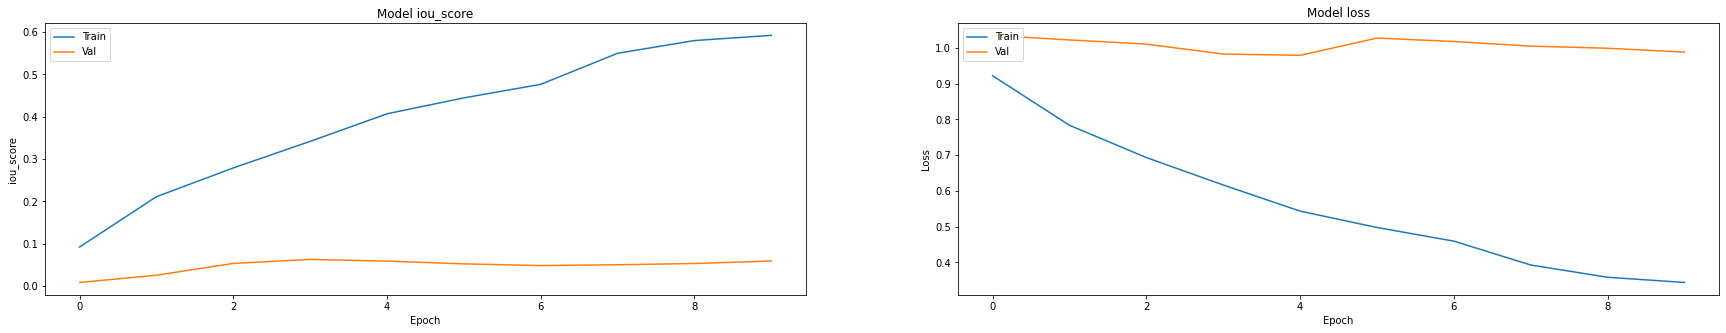

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [13]:
VOC_COLORMAP = [
        [0, 0, 0],
        [128, 0, 0],
        [0, 128, 0],
        [128, 128, 0],
        [0, 0, 128],
        [128, 0, 128],
        [0, 128, 128],
        [128, 128, 128],
        [64, 0, 0],
        [192, 0, 0],
        [64, 128, 0],
        [192, 128, 0],
        [64, 0, 128],
        [192, 0, 128],
        [64, 128, 128],
        [192, 128, 128],
        [0, 64, 0],
        [128, 64, 0],
        [0, 192, 0],
        [128, 192, 0],
        [0, 64, 128],
    ]

def decode_segmentation_masks(mask):
    mask = np.argmax(mask, axis=-1)
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, 21):
        idx = mask == l
        r[idx] = VOC_COLORMAP[l][0]
        g[idx] = VOC_COLORMAP[l][1]
        b[idx] = VOC_COLORMAP[l][2]
    rgb = np.stack([r, g, b], axis=-1)
    return rgb

2022-07-24 20:23:06.428362: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-07-24 20:23:08.644264: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 5s 5s/step


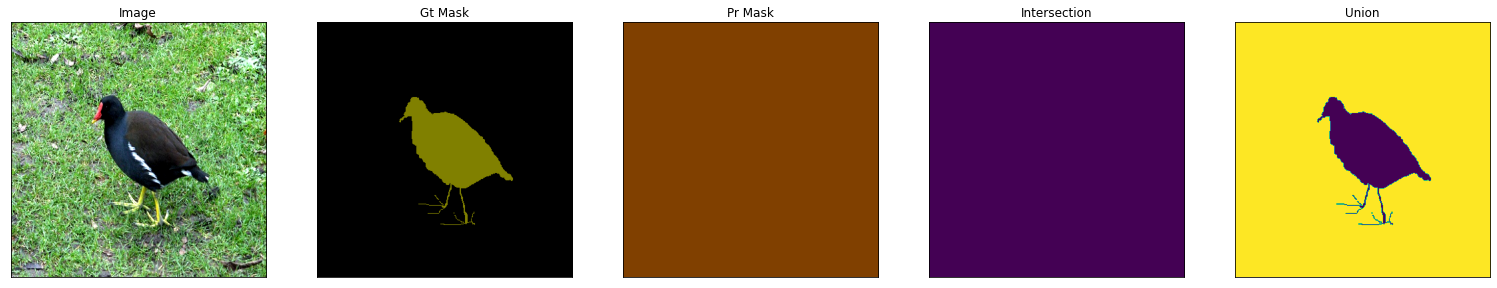

1/1 [==============================] - 0s 15ms/step


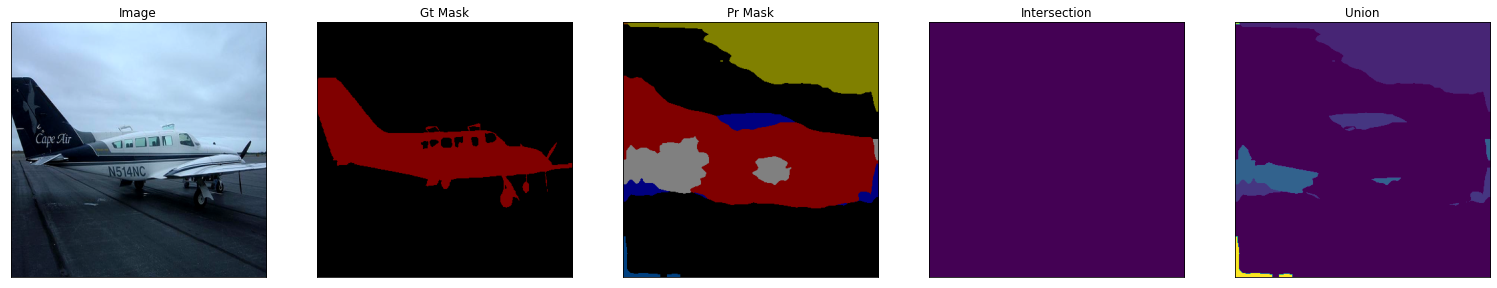

1/1 [==============================] - 0s 15ms/step


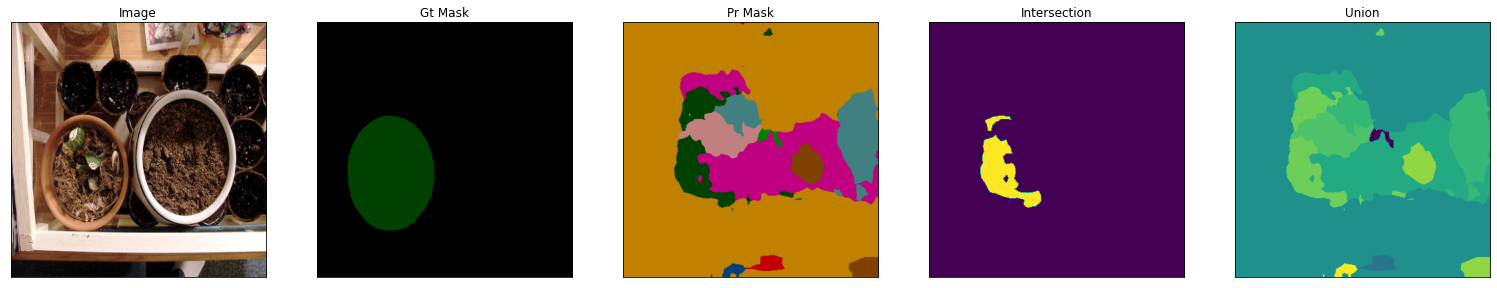

1/1 [==============================] - 0s 14ms/step


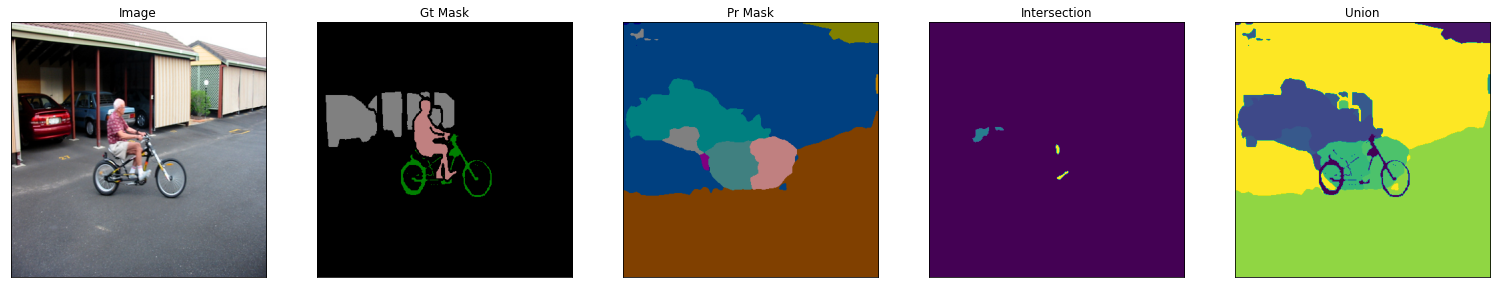

1/1 [==============================] - 0s 15ms/step


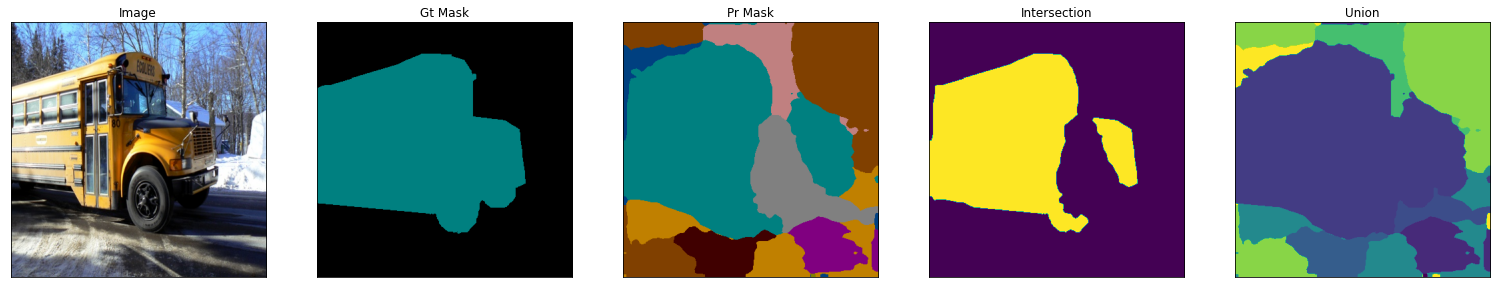

In [14]:
n = 5
ids = np.random.choice(np.arange(len(train_dataset)), size=n)

for i in ids:
    
    image, gt_mask = val_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = net.predict(image)

    pr_mask_f = K.flatten(K.one_hot(K.argmax(pr_mask, axis=-1), num_classes=21)[..., 1:])
    gt_mask_f = K.flatten(gt_mask[..., 1:])
    
    intersection = pr_mask_f * gt_mask_f
    union = pr_mask_f + gt_mask_f

    visualize(
        image=denormalize(image.squeeze()), 
        gt_mask=decode_segmentation_masks(gt_mask.squeeze()),
        pr_mask=decode_segmentation_masks(pr_mask.squeeze()),
        intersection=np.argmax(K.reshape(intersection, (image_height, image_width, 20)), axis=-1),
        union=np.argmax(K.reshape(union, (image_height, image_width, 20)), axis=-1),
    )
